## Disease dynamics in a population of households in Julia

*Author*: Tim Kinyanjui @timothykinyanjui

*Date*: 2018-10-04

In [1]:
# Set the required model parameters for the SIRS model with two levels of transmission - Within and between households
N = 10; # Household size - Change to 10 for final analysis
betaHH = 6; # Within household transmission parameter
betaG = 1; # Population wide transmission
gamma = 1; # Rate of recovery from infection
tau = 1; # Rate of loss of protection
params = [betaHH,gamma,tau,betaG,N]; # Put all the parameters together
time = (0.0, 30.0) # Simulation time - note it defined as a float
dim = dim = 0.5*(N+1)*(N+2); # Number of possible configurations - works for three epidemiological classes
y0 = vec(zeros(1,dim)); # Initial condition vector
y0[end-1] = 0.00000001;
y0[end] = 0.99999999;

In [2]:
function hhTransitions(N,dim)
    # Function to generate transition matrices for household model
    # Input: N is the household size
    
    # Initialize things
    Qinf = zeros(dim,dim);
    Qrec = zeros(dim,dim);
    Qext = zeros(dim,dim);
    Qwane = zeros(dim,dim);
    dataI = Array{Int64}(zeros(dim,3))
    m = 0;
    I = Array{Int64}(zeros(N+1,N+1))
    
    # To help remember where to store the variables
    for ss = 0:N
        for ii = 0:(N-ss)
            m = m + 1;
            I[ss+1,ii+1] = m
        end
    end
    
    # Describe the epidemiological transitions
    
    # Counter for susceptibles
    for ss = 0:N
        # Counter for infecteds
        for ii = 0:(N-ss) 
            # If susceptibles and infecteds are more than 1, then infection within the household can occur
            if (ss > 0 && ii > 0) 
                Qinf[I[ss+1,ii+1],I[ss,ii+2]] = ii*ss/(N-1);
            end
            
            # If infecteds are more than 1, recovery can occur
            if ii > 0
                # Rate of recovery
                Qrec[I[ss+1,ii+1],I[ss+1,ii]] = ii; 
            end
            
            # For external infection - just keep track of susceptibles
            if ss > 0           
                # Rate of within household infection
                Qext[I[ss+1,ii+1],I[ss,ii+2]] = ss;           
            end
            
            # Loss of protection hence becoming susceptible again. Possible if N-ss-ii = rr > 0 
            if (N-ss-ii) > 0
                # Rate of loss of protection
                Qwane[I[ss+1,ii+1],I[ss+2,ii+1]] = N-ss-ii;
            end
            
            # Store the relevant indices to help identify the household configurations
            dataI[I[ss+1,ii+1],:] = [ss, ii, N-ss-ii];
        end
    end
    
    Qinf = Qinf - diagm(vec(sum(Qinf,2)),0);
    Qrec = Qrec - diagm(vec(sum(Qrec,2)),0);
    Qext = Qext - diagm(vec(sum(Qext,2)),0);
    Qwane = Qwane - diagm(vec(sum(Qwane,2)),0);
    
    # Return
    return Qinf, Qrec, Qext, Qwane, dataI
end
Qinf, Qrec, Qext, Qwane, dataI = hhTransitions(N,dim);

In [3]:
using DifferentialEquations
function rateSIRS(dy_dt,y0,params,time)
    
    # Extract the parameters
    betaHH = params[1];
    gamma = params[2];
    tau = params[3];
    betaG = params[4];
    N = params[5];
    
    # Generate the transition matrices
    Qinf, Qrec, Qext, Qwane, HHconfig = hhTransitions(N,dim);
    
    # Combine within and external transitions
    Q = betaHH*Qinf + gamma*Qrec + tau*Qwane + (betaG*((HHconfig[:,2]'*y0)/N)*Qext);
    
    # Generate the rates of change for ODE solver
    dy_dt .= (y0'*Q)';
    
    # Alternatively this works too
    #=for i=1:length(y0)
        dy_dt[i] = y0'*Q[:,i]
    end=#

end

# Define the ODE problem
prob = ODEProblem(rateSIRS,y0,time,params);

# Solve
sol = solve(prob);

In [4]:
using Plots

In [5]:
Iconfig = dataI[:,2];
infProp = zeros(length(sol.t),1);

# Prepare the plots
for i = 1:length(sol.t)
    infProp[i,1] = sol[:,i]'*Iconfig/N;
end

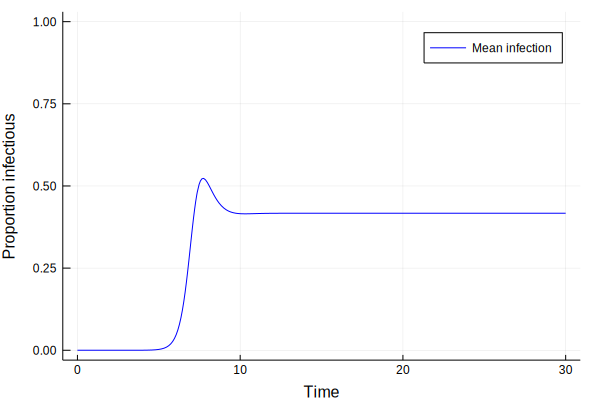

In [6]:
# Total infectious in the population
plot(sol.t,infProp,color="blue",xlabel="Time",ylabel="Proportion infectious",label=["Mean infection"],ylims=[0, 1])

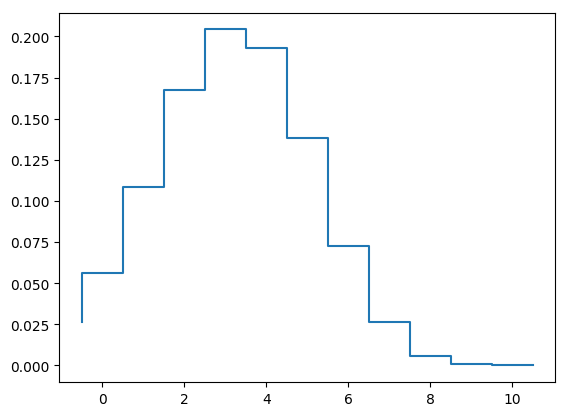

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe91ef1c210>

In [7]:
# Household profile at endemic prevalence
# Prepare the plots
using PyPlot
yprop = zeros(N+1,length(sol.t))
for j = 1:length(sol.t)
    for i = 1:N+1
        index = find(Iconfig.==i-1);
        yprop[i,j] = sum(sol[index,j])
    end
end
step(-0.5:1:10.5,[yprop[:,length(sol.t)];0])

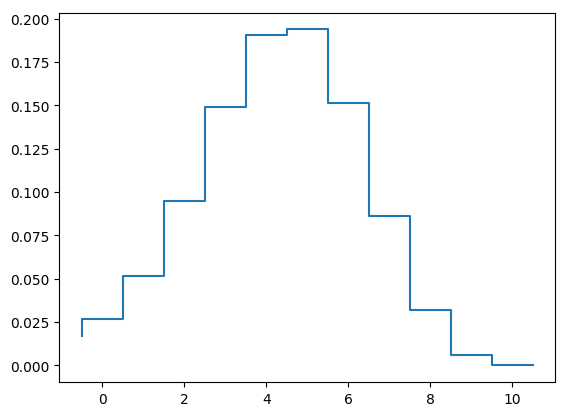

In [8]:
# Household profile at peak prevalence
# Prepare the plots
x = find(infProp.==maximum(infProp))
step(-0.5:1:10.5,[yprop[:,x];0]);